# Textual Analysis of M&As

## Load in TNIC Dataset 

In [20]:
import pandas as pd
import numpy as np

tnic_2023 = pd.read_csv('tnic3_data.txt', sep='\t')

tnic_2023.to_feather('/Users/longer/Textual_Analysis/tnic3_data.txt.feather')

# print preview of tnic df
print(tnic_2023.head())

# lets only use the acqs from 2023
tnic_2023 = tnic_2023[tnic_2023['year'] == 2023].copy()

   year  gvkey1  gvkey2   score
0  1988    1011    3226  0.1508
1  1988    1011    6282  0.0851
2  1988    1011    6734  0.0258
3  1988    1011    7609  0.0097
4  1988    1011    9526  0.0369


# Load in 'gvkey' Dataset

In [6]:

# import the Compustat Annual csv
compustat_path = '/Users/longer/Textual_Analysis/gvkey.csv'
gvkey = pd.read_csv(compustat_path)

print(gvkey.head())

  costat curcd datafmt indfmt consol  gvkey    datadate  \
0      A   USD     STD   INDL      C   1004  2023-05-31   
1      A   USD     STD   INDL      C   1045  2023-12-31   
2      A   USD     STD   INDL      C   1050  2023-12-31   
3      A   USD     STD     FS      C   1062  2023-11-30   
4      A   USD     STD   INDL      C   1062  2023-11-30   

                           conm   tic  fyrc   sic    ebitda       revt  
0                      AAR CORP   AIR     5  5080   179.300   1990.600  
1   AMERICAN AIRLINES GROUP INC   AAL    12  4512  6267.000  52788.000  
2       CECO ENVIRONMENTAL CORP  CECO    12  3564    52.695    544.845  
3  ASA GOLD AND PRECIOUS METALS   ASA    11  6799       NaN     13.018  
4  ASA GOLD AND PRECIOUS METALS   ASA    11  6799    -1.079      2.394  


## Explore Both Datasets

In [8]:

# show all columns in the gvkey df
print(gvkey.columns)

Index(['costat', 'curcd', 'datafmt', 'indfmt', 'consol', 'gvkey', 'datadate',
       'conm', 'tic', 'fyrc', 'sic', 'ebitda', 'revt'],
      dtype='object')


+ gvkey - Global company key
    + Used to link numbers from tnic df
+ conm - Company name
    + Can make TNIC df readable and relatable
+ tic - Stock ticker
    + Helpful for matching exact company to SEC filings
+ sic - Industry code
    + Useful for future analysis
+ ebitda - Earnings before...
+ revt - Revenue
+ Rest of variables are fairly irrelevant

In [10]:

# drop unnecessary columns
gvkey = gvkey.drop(columns=['costat', 'curcd', 'datafmt', 'indfmt', 'consol', 'fyrc', 'datadate'])
gvkey.head()

,gvkey,conm,tic,sic,ebitda,revt
0,1004,AAR CORP,AIR,5080,179.300,1990.600
1,1045,AMERICAN AIRLINES GROUP INC,AAL,4512,6267.000,52788.000
2,1050,CECO ENVIRONMENTAL CORP,CECO,3564,52.695,544.845
3,1062,ASA GOLD AND PRECIOUS METALS,ASA,6799,NaN,13.018
4,1062,ASA GOLD AND PRECIOUS METALS,ASA,6799,-1.079,2.394


# Verify dataframe integrity and create a few graphs for visualization

In [12]:

# lets check for any empty entries
print(gvkey.isna().sum())
print(f'Length of dataset: {len(gvkey)}')

gvkey        0
conm         0
tic          6
sic          0
ebitda    5848
revt      4655
dtype: int64
Length of dataset: 13400


+ Only 6 missing tickers
    + Lets drop these 6 instances
+ Around half of the transactions are missing ebidta and revt
    + Can fill these holes with 0s and can reference SEC filings if needed

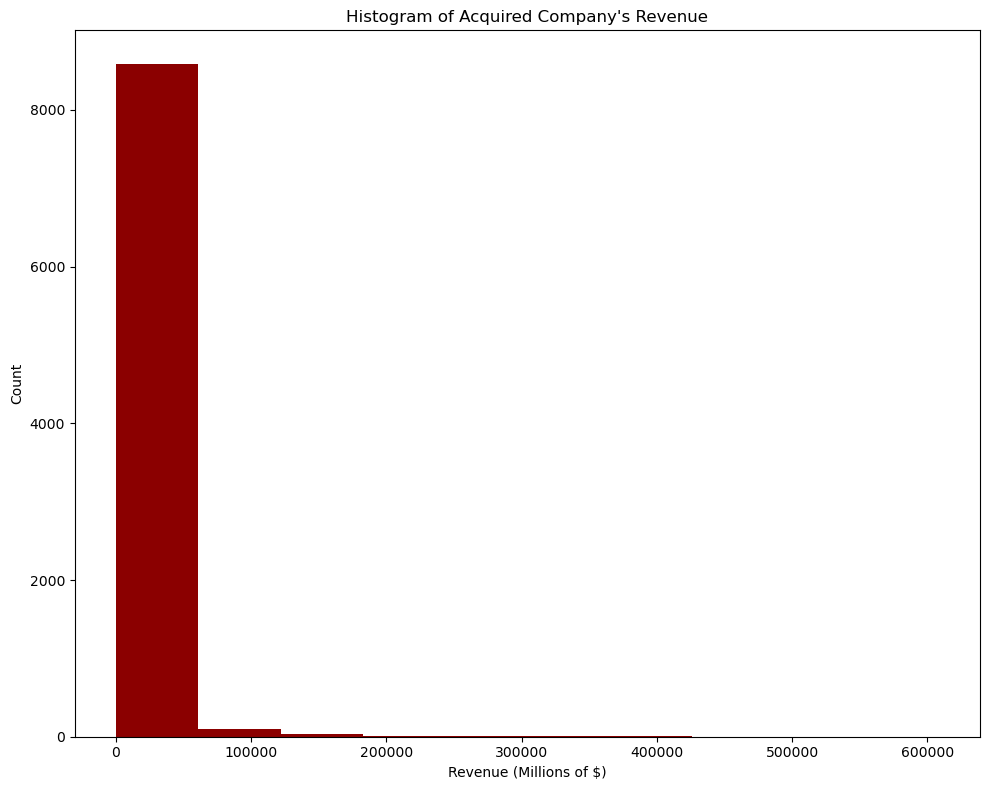

In [16]:

# drop the 6 rows that are missing ticker
gvkey = gvkey[gvkey['tic'].notnull()]

# lets create a graph or two visualizing the sizes of these companies involved in acquisitions
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.hist(gvkey['revt'], bins=10, color='darkred')
plt.title("Histogram of Acquired Company's Revenue")
plt.xlabel('Revenue (Millions of $)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# Merge gvkey on TNIC Dataset

In [21]:

# to properly merge the two datasets, lets create a name/ticker map
gvkey_name_map = gvkey[['gvkey', 'conm', 'tic']]

gvkey_name_map = gvkey_name_map.rename(columns={
    'gvkey': 'gvkey',
    'conm' : 'company_name',
    'tic' : 'ticker'
})

# merge tnic with firm side

tnic_named = tnic_2023.merge(
    gvkey_name_map,
    how='left',
    left_on='gvkey1',
    right_on='gvkey' 
).rename(columns={
    'company_name' : 'firm_name',
    'ticker' : 'firm_ticker'
}).drop('gvkey', axis=1)

# merge tnic with peer side
tnic_named = tnic_named.merge(
    gvkey_name_map, 
    how='inner', 
    left_on='gvkey2',
    right_on='gvkey'
).rename(columns={
    'company_name' : 'peer_name',
    'ticker' : 'peer_ticker'
}).drop('gvkey', axis=1)

tnic_named = tnic_named[[
    'year', 'gvkey1', 'firm_name', 'firm_ticker', 'gvkey2', 'peer_name', 'peer_ticker', 'score'
]]

tnic_named.head()

,year,gvkey1,firm_name,firm_ticker,gvkey2,peer_name,peer_ticker,score
0,2023,1004,AAR CORP,AIR,1823,ASTRONICS CORP,ATRO,0.0127
1,2023,1004,AAR CORP,AIR,4091,DUCOMMUN INC,DCO,0.0087
2,2023,1004,AAR CORP,AIR,5567,HEICO CORP,HEI,0.0063
3,2023,1004,AAR CORP,AIR,9698,SIFCO INDUSTRIES,SIF,0.0075
4,2023,1004,AAR CORP,AIR,10519,TEXTRON INC,TXT,0.0191


In [24]:

print(f'Number of Acqs occured in 2023: {len(tnic_named)}')

Number of Acqs occured in 2023: 1047917
